In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as pdr
from statsmodels import api as sm
from re import match
from datetime import datetime as dt
from sqlalchemy import create_engine
import mplfinance as mplf

sns.set()
sns.set(rc={'figure.figsize':(30,8)})
SNS_CMAP = sns.light_palette("seagreen", as_cmap=True)
SNS_COLOR = sns.color_palette('muted')

## Minute DB

In [556]:
symbols = ['EURUSD']#,'USDJPY','GBPUSD','USDCHF','AUDUSD','USDCAD','NZDUSD']

db_url = 'sqlite:///data/minute_data/fx_min_data.db'
db_engine = create_engine(db_url, echo=False)

data = dict()
for symbol in symbols:
    query = f'''
SELECT "Datetime","Open","High","Low","Close","Volume" FROM {symbol}
WHERE Datetime >= "2000-01-01"
ORDER BY Datetime ASC
'''
    df = pd.read_sql(query,db_engine,
                    index_col='Datetime')
    df.index = pd.DatetimeIndex(df.index)
    df.sort_index(inplace=True)
    df = df[~df.index.duplicated(keep='first')] # drop duplicates
    data[symbol] = df
db_engine.dispose()

In [557]:
def resample(data,freq='1h',open='Open',high='High',low='Low',close='Close',volume='Volume'):
  o,h,l,c,v = data[open],data[high],data[low],data[close],data[volume]
  sample = pd.DataFrame()
  sample[open] = o.resample(freq).first()
  sample[high] = h.resample(freq).max()
  sample[low] = l.resample(freq).min()
  sample[close] = c.resample(freq).last()
  sample[volume] = v.resample(freq).sum()
  return sample

In [558]:
for symbol in symbols:
  data[symbol] = resample(data[symbol],freq='d').dropna()

# Yfinance

In [4]:
data = dict()

In [26]:
symbols = ['SPY']
for symbol in symbols:
  data[symbol] = yf.download(symbol).drop(columns='Adj Close')
  data[symbol].index.name = 'Datetime'

[*********************100%***********************]  1 of 1 completed


# Strategy

In [376]:
'''
# Counter Vol
def CVOL(close,window):
  dir = np.sign(np.log(close).diff(window))
  vol = np.log(close).diff().rolling(window).std()
  spike = np.where(vol > vol.expanding().quantile(0.95),1,0)
  signal = -dir * spike
  return signal

def EWMAC(close,window):
  fast = close.ewm(window).mean()
  slow = close.ewm(window*4).mean()
  ewmac = fast - slow
  signal = np.sign(ewmac)
  return signal

def DCB(high,low,close,window):
  upper = high.rolling(window).max().shift(1)
  lower = low.rolling(window).min().shift(1)
  long = np.where(close > upper,1,0)
  short = np.where(close < lower,-1,0)
  signal = long + short
  return signal

def MR(close,window):
  mean = close.rolling(window).mean()
  vol = np.log(close).diff().rolling(window).std()
  z = (close - mean) / (vol * close).shift(1)
  long = np.where(z < -1.5,1,0)
  short = np.where(z > 1.5,-1,0)
  signal = long + short
  return signal
'''

In [414]:
# Counter Vol
def CVOL(close,window):
  dir = np.sign(np.log(close).diff(window))
  vol = np.log(close).diff().rolling(window).std()
  z_vol = (vol - vol.rolling(window).mean()) / vol.rolling(window).std()
  signal = -dir * z_vol
  signal = signal / signal.abs().expanding().mean()
  signal = signal.clip(lower=-2,upper=2)
  return signal

def EWMAC(close,window):
  fast = close.ewm(window).mean()
  slow = close.ewm(window*4).mean()
  ewmac = fast - slow
  vol = np.log(close).diff().rolling(21).std()
  signal = ewmac / (vol * close)
  signal = signal / signal.abs().expanding().mean()
  signal = signal.clip(lower=-2,upper=2)
  return signal

def DCB(high,low,close,window):
  upper = high.rolling(window).max().shift(1)
  lower = low.rolling(window).min().shift(1)
  middle = (upper + lower) / 2
  signal = (close - middle) / (upper - lower) * 2
  signal = signal / signal.abs().expanding().mean()
  signal = signal.clip(lower=-2,upper=2)
  return signal

def MR(close,window):
  mean = close.rolling(window).mean()
  vol = np.log(close).diff().rolling(window).std()
  z = (close - mean) / (vol * close).shift(1)
  signal = -z
  signal = signal / signal.abs().expanding().mean()
  signal = signal.clip(lower=-2,upper=2)
  return signal

In [464]:
signals = dict()

for symbol in symbols:
  o,h,l,c,v = data[symbol].Open,data[symbol].High,data[symbol].Low,data[symbol].Close,data[symbol].Volume
  signal = pd.DataFrame()

  #for speed in [20,40,60,80]:
  #  signal[f'CVOL_{speed}'] = CVOL(c,speed)

  for speed in [16,32,48,64]:
    signal[f'EWMAC_{speed}'] = EWMAC(c,speed)
    
  #for speed in [20,60,120,240]:
  #  signal[f'DCB_{speed}'] = DCB(h,l,c,speed)

  for speed in [5,10,15,20]:
   signal[f'MR_{speed}'] = MR(c,speed)
  
  signals[symbol] = signal

<Axes: >

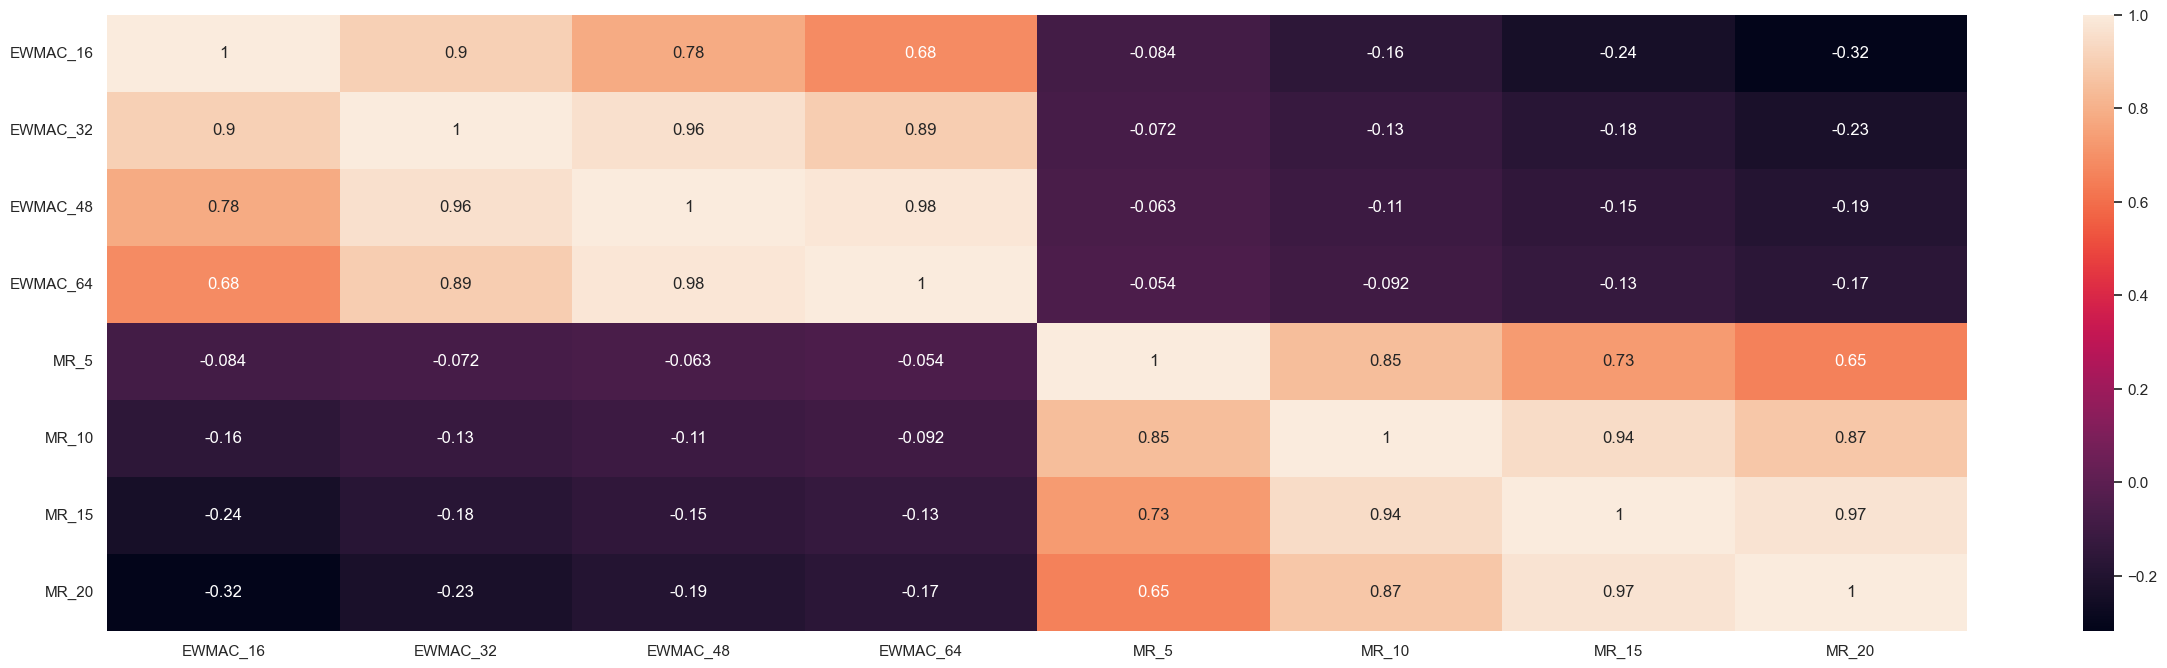

In [465]:
sns.heatmap(signal.corr(),annot=True)

In [466]:
pnls = dict()

for symbol in symbols:
  logprc = np.log(data[symbol].Close)
  vol = logprc.rolling(252).std() # scaling the profit
  
  pnl = signals[symbol].mul((logprc.diff().shift(-1)),axis=0)
  
  pnls[symbol] = pnl #- 0.00006 * signals[symbol].diff().abs()

In [467]:
train_index = pnl.index[:round(pnl.shape[0]*0.5)]

EWMAC_16: 0.2655772864564612
EWMAC_32: 0.434605985692202
EWMAC_48: 0.4606724714477113
EWMAC_64: 0.4503603384584841
MR_5: 0.6875450177940161
MR_10: 0.8545265621391966
MR_15: 0.6932187463904417
MR_20: 0.5539968240870642


<Axes: xlabel='Datetime'>

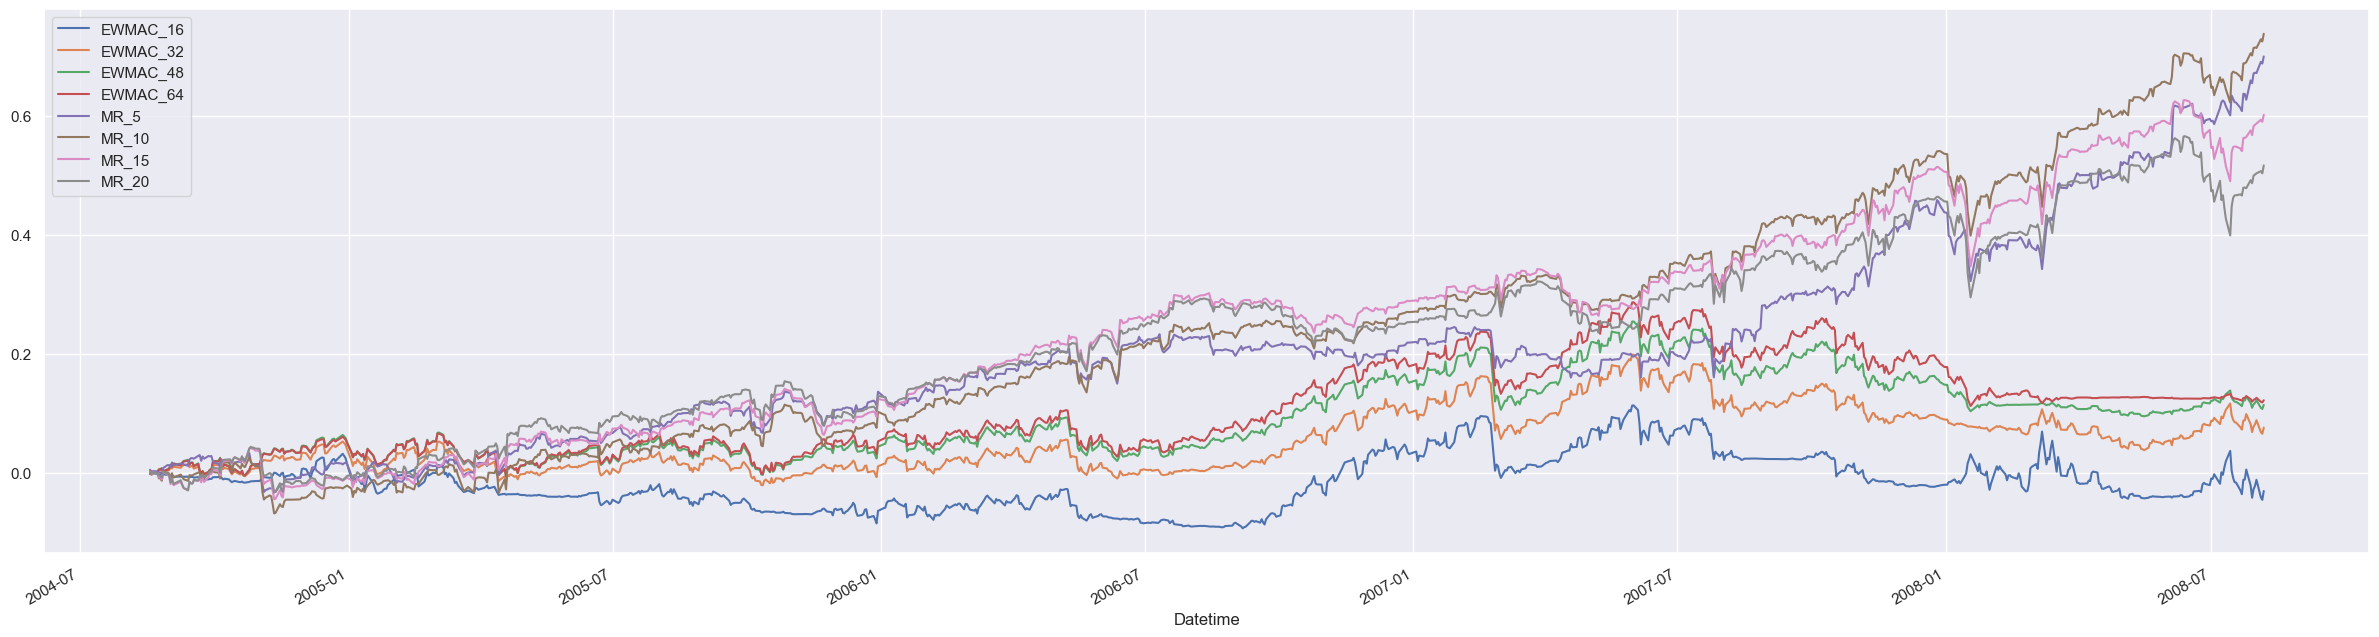

In [468]:
for name in signal.columns:
  daily_pnl = pnl[name].loc[train_index]
  mu = daily_pnl.mean()
  sig = daily_pnl.std()
  sr = mu / sig * 252**0.5
  print(f'{name}: {sr}')
pnl.loc[train_index][-1000:].cumsum().plot()

# Metalabelling

In [503]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(np.around(dfoutput,6))

In [519]:
features = dict()
for symbol in symbols:
  features[symbol] = pd.DataFrame(index=data[symbol].index)

## TA features

In [518]:
from ta.momentum import RSIIndicator as RSI
from ta.momentum import StochasticOscillator as STO
from ta.volume import VolumeWeightedAveragePrice as VWAP
from ta.volatility import AverageTrueRange as ATR
from ta.trend import MACD
from ta.trend import ADXIndicator as ADX

for symbol in symbols:
  o,h,l,c,v = data[symbol].Open,data[symbol].High,data[symbol].Low,data[symbol].Close,data[symbol].Volume
  
  ta = pd.DataFrame()
  for w in [4,8,16,32,64,128,256,512]:
    ta[f'RSI_{w}'] = RSI(c,w).rsi()
    ta[f'STO_{w}'] = STO(c,h,l,w).stoch()
    ta[f'VLM_{w}'] = np.log(v).ffill().diff().rolling(w).mean()
    ta[f'VWAP_{w}'] = np.log(VWAP(h,l,c,v,w).volume_weighted_average_price()).diff()
    ta[f'VOL_{w}'] = np.log(c).ffill().diff().rolling(w).std()
    ta[f'ATR_{w}'] = (ATR(h,l,c,w).average_true_range())
    ta[f'MACD_{w}'] = MACD(c,
                           window_slow=w*2,
                           window_fast=w,
                           window_sign=w*0.5).macd_diff()
    ta[f'ADX_{w}'] = ADX(h,l,c,w).adx()
  ta.replace([np.inf, -np.inf], np.nan, inplace=True)
  ta.ffill(inplace=True)
  features[symbol] = features[symbol].merge(ta,on='Datetime',how='outer')

## Fundamental features

In [506]:
from pandas_datareader.famafrench import FamaFrenchReader as FFR

fund = pd.DataFrame()
vix = yf.download(['^VIX']).Close
evz = yf.download(['^EVZ']).Close
usd = yf.download(['DX-Y.NYB']).Close
ff5 = FFR('F-F_Research_Data_5_Factors_2x3_daily',start='1990-01-01').read()[0]
fund['VIX'] = vix
#fund['EVZ'] = evz
fund['USD'] = np.log(usd).diff()
fund['MKT'] = ff5['Mkt-RF']
fund['SMB'] = ff5.SMB
fund['HML'] = ff5.HML
fund['RMW'] = ff5.RMW
fund['CMA'] = ff5.CMA
fund['RF'] = ff5.RF
fund.index.name = 'Datetime'

for symbol in symbols:
  features[symbol] = features[symbol].merge(fund,on='Datetime',how='outer')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Test

In [507]:
def center(s):
  mean = s.expanding(252).mean()
  zero_mean_s = s - mean
  return zero_mean_s

def normalize(s):
  zero_mean_var = (s**2).expanding(252).mean()
  zero_mean_std = np.sqrt(zero_mean_var)
  norm_s = s / zero_mean_std
  return norm_s

def smooth(s):
  return s.ewm(alpha=0.05).mean()

In [508]:
for symbol in symbols:
  features[symbol] = features[symbol].apply(center).apply(normalize)

In [509]:
def label(s):
  win = np.where(s>0,1,0)
  label = pd.Series(win,index=s.index)
  return label

In [510]:
from sklearn.ensemble import RandomForestClassifier

meta_preds = dict()

for symbol in symbols:
  pnl = pnls[symbol]
  feature = features[symbol]
  signal = signals[symbol]
  logprc = np.log(data[symbol].Close)
  vol = logprc.diff().rolling(252).std()
  meta_pred = pd.DataFrame()
  
  for strat in pnl.columns:
    print(f'Fitting {symbol} {strat}')
    #w = int(strat.split('_')[1])
    pnl_label = label(pnl[strat] / vol)
    
    df = pd.concat([pnl_label,feature],axis=1).ffill().dropna()
    rf = RandomForestClassifier(n_estimators=1000,max_depth=3)

    train_index = df.index[:round(df.shape[0]*0.5)]
    val_index = df.index[round(df.shape[0]*0.5)+21:round(df.shape[0]*0.7)]
    test_index = df.index[round(df.shape[0]*0.7)+21:]

    rf.fit(y=df.iloc[:,0].loc[train_index],
           X=df.iloc[:,1:].loc[train_index])
    
    pred = pd.Series(rf.predict(X=df.iloc[:,1:]),index=df.index)
    meta_pred[strat] = pred
  
  meta_preds[symbol] = meta_pred
    #valid = pd.DataFrame()
    #valid['true'] = df.iloc[:,0].loc[train_index]
    #valid['pred'] = rf.predict(X=df.iloc[:,1:].loc[train_index])
    #valid['tp'] = np.where(valid.true == valid.pred,1,0)
    #print(valid['tp'].mean())

Fitting SPY EWMAC_16
Fitting SPY EWMAC_32
Fitting SPY EWMAC_48
Fitting SPY EWMAC_64
Fitting SPY MR_5
Fitting SPY MR_10
Fitting SPY MR_15
Fitting SPY MR_20


In [511]:
meta_pnls = dict()

for symbol in symbols:
  pnl = pnls[symbol]
  meta_pred = meta_preds[symbol]
  signal = signals[symbol]
  logprc = np.log(data[symbol].Close)
  
  #z = (meta_pred-0.5)/(meta_pred*(1-meta_pred))
  #z = ((z-z.expanding().mean())/z.expanding().std()).clip(lower=-2,upper=2)
  meta_signal = signal * meta_pred#.clip(lower=0)
  #for strat in signal.columns:
  #  w = int(strat.split('_')[1])
  #  meta_signal[strat] = meta_signal[strat].rolling(w).mean()
    
  meta_pnl = meta_signal.mul(logprc.diff().shift(-1),axis=0) #- 0.00006 * meta_signal.diff().abs()
  meta_pnls[symbol] = meta_pnl

In [514]:
sr_df = pd.DataFrame()

for symbol in symbols:
  meta_pnl = meta_pnls[symbol]
  pnl = pnls[symbol]
  for strat in pnl.columns:
    daily_meta_pnl = meta_pnl.loc[val_index,strat]
    daily_pnl = pnl.loc[val_index,strat]
    
    meta_mu = daily_meta_pnl.mean()
    meta_sig = daily_meta_pnl.std()
    meta_sr = meta_mu / meta_sig * 252**0.5
    
    mu = daily_pnl.mean()
    sig = daily_pnl.std()
    sr = mu / sig * 252**0.5
    
    sr_df.loc[strat,'vanilla'] = sr
    sr_df.loc[strat,'meta'] = meta_sr
  print(symbol)
  print(sr_df)

SPY
           vanilla      meta
EWMAC_16  0.212462  0.311806
EWMAC_32  0.382991  0.355105
EWMAC_48  0.436475  0.438766
EWMAC_64  0.440521  0.300314
MR_5      0.463400  0.679328
MR_10     0.688522  0.720045
MR_15     0.642204  0.750880
MR_20     0.637174  0.732907


In [ ]:
SPY
           vanilla      meta
EWMAC_16 -0.205188 -0.152883
EWMAC_32  0.194548  0.255893
EWMAC_48  0.358504  0.355616
EWMAC_64  0.434452  0.312650
MR_5      0.630654  0.735247
MR_10     0.877377  0.799895
MR_15     0.918170  0.919904
MR_20     0.936264  1.127212

In [515]:
meta_pnl.loc[test_index].mean(axis=1).std()*252**0.5

0.13445044923485608

In [516]:
np.log(data['SPY'].Close).diff().loc[test_index].std()*252**0.5

0.18460478279885817

<Axes: xlabel='Datetime'>

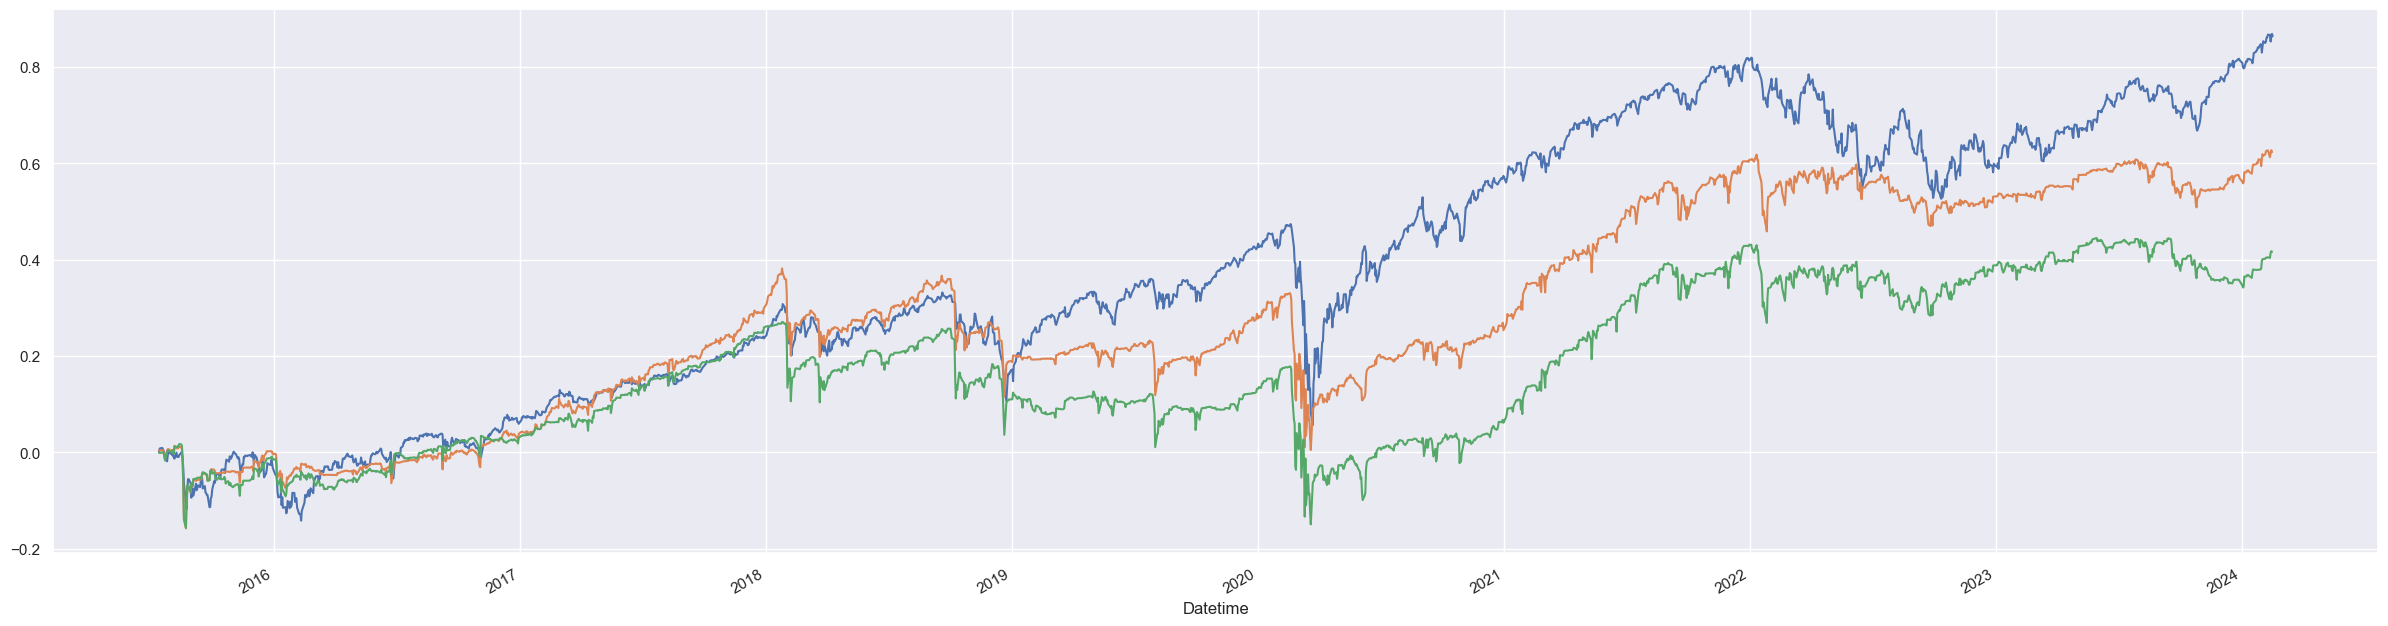

In [517]:
np.log(data['SPY'].Close).diff().loc[test_index].cumsum().plot()
(pd.concat(meta_pnls.values(),axis=1).mean(axis=1).loc[test_index]*1.35).cumsum().plot()
(pd.concat(pnls.values(),axis=1).mean(axis=1).loc[test_index]*1.35).cumsum().plot()